In [2]:
!pip install transformers sentencepiece datasets

In [3]:
!pip install seaborn

In [4]:
from datasets import load_dataset

from IPython.display import display
from IPython.html import widgets
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import optim
from torch.nn import functional as F
from transformers import AdamW, AutoModelForSeq2SeqLM, AutoTokenizer
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm_notebook

sns.set()

/opt/conda/lib/python3.8/site-packages/IPython/html.py:12: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  warn("The `IPython.html` package has been deprecated since IPython 4.0. "


In [5]:
model_repo = 'Helsinki-NLP/opus-mt-en-hi'
model_path = 'model/t5_translation.pt'
max_seq_len = 20

In [6]:
tokenizer = AutoTokenizer.from_pretrained(model_repo)

In [7]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_repo)
model = model.cuda()

In [8]:
token_ids = tokenizer.encode(
    '<de> This will be translated to German! (hopefully)',
    return_tensors='pt').cuda()
print(token_ids)

model_out = model.generate(token_ids)
print(model_out)

output_text = tokenizer.convert_tokens_to_string(
    tokenizer.convert_ids_to_tokens(model_out[0]))
print(output_text)

tensor([[ 2843,  4955,  3520,   239,    46,    42,  6732,     7,  5875,    61,
            17, 38203, 12944,    13,     0]], device='cuda:0')
tensor([[61949,  2843,   232,  3520,    60,  9144,    18, 15943,    78,   368,
            61,    17, 23583,     5,    13,     0]], device='cuda:0')
<pad> <d> यह जर्मन को अनुवादित किया जाएगा! (आशा है)


In [9]:
example_input_str = '<es>This is just a test nbuig.'

input_ids = tokenizer.encode(example_input_str, return_tensors='pt')
print('Input IDs:', input_ids)

tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
print('Tokens:', tokens)

Input IDs: tensor([[ 2843,  1411,  3520,  1687,    23,   469,    19,  2564,  6532, 17448,
          7320,     3,     0]])
Tokens: ['▁<', 'es', '>', 'This', '▁is', '▁just', '▁a', '▁test', '▁n', 'bu', 'ig', '.', '</s>']


In [10]:
from datasets import load_dataset, Dataset

dataset = load_dataset("opus100", "en-hi")

Dataset opus100 downloaded and prepared to /root/.cache/huggingface/datasets/opus100/en-hi/0.0.0/a87abd612d82947c7a2c3991f71095a98f55141af7ad37516dfb31bfa3511ddc. Subsequent calls will reuse this data.


In [11]:
train_dataset = dataset['train']
test_dataset = dataset['test']

In [13]:
LANG_TOKEN_MAPPING = {
    'en': '<en>',
    'hi': '<hi>',
}

In [14]:
special_tokens_dict = {'additional_special_tokens': list(LANG_TOKEN_MAPPING.values())}
tokenizer.add_special_tokens(special_tokens_dict)
model.resize_token_embeddings(len(tokenizer))

Embedding(61952, 512)

In [15]:
token_ids = tokenizer.encode(
    example_input_str, return_tensors='pt', padding='max_length',
    truncation=True, max_length=max_seq_len)
print(token_ids)

tokens = tokenizer.convert_ids_to_tokens(token_ids[0])
print(tokens)

tensor([[ 2843,  1411,  3520,  1687,    23,   469,    19,  2564,  6532, 17448,
          7320,     3,     0, 61949, 61949, 61949, 61949, 61949, 61949, 61949]])
['▁<', 'es', '>', 'This', '▁is', '▁just', '▁a', '▁test', '▁n', 'bu', 'ig', '.', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


In [16]:
def encode_input_str(text, target_lang, tokenizer, seq_len,
                     lang_token_map=LANG_TOKEN_MAPPING):
  target_lang_token = lang_token_map[target_lang]

  # Tokenize and add special tokens
  input_ids = tokenizer.encode(
      text = target_lang_token + text,
      return_tensors = 'pt',
      padding = 'max_length',
      truncation = True,
      max_length = seq_len)

  return input_ids[0]
  
def encode_target_str(text, tokenizer, seq_len,
                      lang_token_map=LANG_TOKEN_MAPPING):
  token_ids = tokenizer.encode(
      text = text,
      return_tensors = 'pt',
      padding = 'max_length',
      truncation = True,
      max_length = seq_len)
  
  return token_ids[0]

def format_translation_data(translations, lang_token_map,
                            tokenizer, seq_len=128):
  # Choose a random 2 languages for in i/o
  langs = list(lang_token_map.keys())
  input_lang, target_lang = np.random.choice(langs, size=2, replace=False)

  # Get the translations for the batch
  input_text = translations[input_lang]
  target_text = translations[target_lang]

  if input_text is None or target_text is None:
    return None

  input_token_ids = encode_input_str(
      input_text, target_lang, tokenizer, seq_len, lang_token_map)
  
  target_token_ids = encode_target_str(
      target_text, tokenizer, seq_len, lang_token_map)

  return input_token_ids, target_token_ids

def transform_batch(batch, lang_token_map, tokenizer):
  inputs = []
  targets = []
  for translation_set in batch['translation']:
    formatted_data = format_translation_data(
        translation_set, lang_token_map, tokenizer, max_seq_len)
    
    if formatted_data is None:
      continue
    
    input_ids, target_ids = formatted_data
    inputs.append(input_ids.unsqueeze(0))
    targets.append(target_ids.unsqueeze(0))
    
  batch_input_ids = torch.cat(inputs).cuda()
  batch_target_ids = torch.cat(targets).cuda()

  return batch_input_ids, batch_target_ids

def get_data_generator(dataset, lang_token_map, tokenizer, batch_size=32):
  dataset = dataset.shuffle()
  for i in range(0, len(dataset), batch_size):
    raw_batch = dataset[i:i+batch_size]
    yield transform_batch(raw_batch, lang_token_map, tokenizer)

In [17]:
# Testing `data_transform`
in_ids, out_ids = format_translation_data(
    train_dataset[0]['translation'], LANG_TOKEN_MAPPING, tokenizer)

print(' '.join(tokenizer.convert_ids_to_tokens(in_ids)))
print(' '.join(tokenizer.convert_ids_to_tokens(out_ids)))

# Testing data generator
data_gen = get_data_generator(train_dataset, LANG_TOKEN_MAPPING, tokenizer, 8)
data_batch = next(data_gen)
print('Input shape:', data_batch[0].shape)
print('Output shape:', data_batch[1].shape)

<hi> ▁Other , ▁Private ▁Use </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
▁ अ न ् य , ▁ न िज ़ ी ▁ उ प य ो ग </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pa

In [18]:
n_epochs = 1
batch_size = 16
print_freq = 50
checkpoint_freq = 1000
lr = 5e-4
n_batches = int(np.ceil(len(train_dataset) / batch_size))
total_steps = n_epochs * n_batches
n_warmup_steps = int(total_steps * 0.01)

In [19]:
optimizer = AdamW(model.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(
    optimizer, n_warmup_steps, total_steps)

In [20]:
losses = []

In [21]:
def eval_model(model, gdataset, max_iters=8):
  test_generator = get_data_generator(gdataset, LANG_TOKEN_MAPPING,
                                      tokenizer, batch_size)
  eval_losses = []
  for i, (input_batch, label_batch) in enumerate(test_generator):
    if i >= max_iters:
      break

    model_out = model.forward(
        input_ids = input_batch,
        labels = label_batch)
    eval_losses.append(model_out.loss.item())

  return np.mean(eval_losses)

In [22]:
for epoch_idx in range(n_epochs):
  # Randomize data order
  data_generator = get_data_generator(train_dataset, LANG_TOKEN_MAPPING,
                                      tokenizer, batch_size)
                
  for batch_idx, (input_batch, label_batch) \
      in tqdm_notebook(enumerate(data_generator), total=n_batches):
    optimizer.zero_grad()

    # Forward pass
    model_out = model.forward(
        input_ids = input_batch,
        labels = label_batch)

    # Calculate loss and update weights
    loss = model_out.loss
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    scheduler.step()

    # Print training update info
    if (batch_idx + 1) % print_freq == 0:
      avg_loss = np.mean(losses[-print_freq:])
      print('Epoch: {} | Step: {} | Avg. loss: {:.3f} | lr: {}'.format(
          epoch_idx+1, batch_idx+1, avg_loss, scheduler.get_last_lr()[0]))
      
    if (batch_idx + 1) % checkpoint_freq == 0:
      test_loss = eval_model(model, test_dataset)
      print('Saving model with test loss of {:.3f}'.format(test_loss))
      torch.save(model.state_dict(), model_path)

torch.save(model.state_dict(), model_path)

<ipython-input-22-7d82fc3c8b16>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  in tqdm_notebook(enumerate(data_generator), total=n_batches):


Epoch: 1 | Step: 50 | Avg. loss: 5.223 | lr: 7.507507507507507e-05
Epoch: 1 | Step: 100 | Avg. loss: 3.268 | lr: 0.00015015015015015014
Epoch: 1 | Step: 150 | Avg. loss: 2.883 | lr: 0.00022522522522522523
Epoch: 1 | Step: 200 | Avg. loss: 2.696 | lr: 0.0003003003003003003
Epoch: 1 | Step: 250 | Avg. loss: 2.586 | lr: 0.00037537537537537537
Epoch: 1 | Step: 300 | Avg. loss: 2.575 | lr: 0.00045045045045045046
Epoch: 1 | Step: 350 | Avg. loss: 2.606 | lr: 0.0004997429072651382
Epoch: 1 | Step: 400 | Avg. loss: 2.600 | lr: 0.0004989867521626036
Epoch: 1 | Step: 450 | Avg. loss: 2.379 | lr: 0.0004982305970600689
Epoch: 1 | Step: 500 | Avg. loss: 2.413 | lr: 0.0004974744419575343
Epoch: 1 | Step: 550 | Avg. loss: 2.427 | lr: 0.0004967182868549997
Epoch: 1 | Step: 600 | Avg. loss: 2.299 | lr: 0.000495962131752465
Epoch: 1 | Step: 650 | Avg. loss: 2.321 | lr: 0.0004952059766499305
Epoch: 1 | Step: 700 | Avg. loss: 2.318 | lr: 0.0004944498215473959
Epoch: 1 | Step: 750 | Avg. loss: 2.283 | lr: 

In [23]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

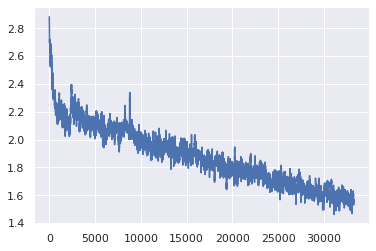

In [24]:
window_size = 50
smoothed_losses = []
for i in range(len(losses)-window_size):
  smoothed_losses.append(np.mean(losses[i:i+window_size]))

plt.plot(smoothed_losses[100:])

In [26]:
test_sentence = test_dataset[0]['translation']['en']
print('Raw input text:', test_sentence)

input_ids = encode_input_str(
    text = test_sentence,
    target_lang = 'hi',
    tokenizer = tokenizer,
    seq_len = model.config.max_length,
    lang_token_map = LANG_TOKEN_MAPPING)
input_ids = input_ids.unsqueeze(0).cuda()

print('Truncated input text:', tokenizer.convert_tokens_to_string(
    tokenizer.convert_ids_to_tokens(input_ids[0])))

Raw input text: Give shots of injections or pills, but he must be alright soon.
Truncated input text: <hi>▁Give▁shots of▁injections or▁pills,▁but▁he▁must be▁alright▁soon.<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>

In [27]:
output_tokens = model.generate(input_ids, num_beams=10, num_return_sequences=3)
# print(output_tokens)
for token_set in output_tokens:
  print(tokenizer.decode(token_set, skip_special_tokens=True))

क्या आप निश्चित हैं कि 
मैं तुम्हारे लिए ा
मैं तुम्हारे लिए एक


In [28]:
output_language = 'en' #@param ["en", "de"]
#@title Slick Blue Translate
input_text = 'A surfboarder ran into a shark' #@param {type:"string"}

input_ids = encode_input_str(
    text = input_text,
    target_lang = output_language,
    tokenizer = tokenizer,
    seq_len = model.config.max_length,
    lang_token_map = LANG_TOKEN_MAPPING)
input_ids = input_ids.unsqueeze(0).cuda()

output_tokens = model.generate(input_ids, num_beams=20, length_penalty=0.2)
print(input_text + '  ->  ' + \
      tokenizer.decode(output_tokens[0], skip_special_tokens=True))

A surfboarder ran into a shark  ->  ▁All▁right.


In [29]:
from datasets import load_dataset, load_metric

metric = load_metric("bleu")

In [30]:
print(f'Bleu = {model.compute_metrics*100:.2f}')

BLeu = 32.16
